<a href="https://colab.research.google.com/github/JuanBailke/Transfer-Learning-DIO/blob/main/Transfer_Learning_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning com TensorFlow/Keras no Colab - Gatos vs Cachorros

### Projeto criado para Treinamento de Redes Neurais com Transfer Learning do bootcamp [BairesDev - Machine Learning Training](https://web.dio.me/track/bairesdev-machine-learning-training)

## 1. Download e extração do dataset

In [1]:
!wget -O cats_and_dogs.zip "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"
!unzip -q cats_and_dogs.zip -d dataset/

--2025-08-03 16:02:11--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:3c00:c80::317f, 2600:1409:3c00:c8c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>] 786.67M   218MB/s    in 3.7s    

2025-08-03 16:02:15 (213 MB/s) - ‘cats_and_dogs.zip’ saved [824887076/824887076]



## 2. Organização das pastas (train / val split)

In [2]:
import os, shutil, random
from PIL import Image

src = 'dataset/PetImages'
dst = 'dataset_split'
os.makedirs(dst, exist_ok=True)

for label in ['Cat', 'Dog']:
    files = os.listdir(os.path.join(src, label))
    files = [f for f in files if os.path.isfile(os.path.join(src, label, f))]
    random.shuffle(files)
    split = int(0.8 * len(files))
    for phase, subset in [('train', files[:split]), ('val', files[split:])]:
        outdir = os.path.join(dst, phase, label)
        os.makedirs(outdir, exist_ok=True)
        for fname in subset:
            fpath = os.path.join(src, label, fname)
            try:
                with Image.open(fpath) as img:
                  img.verify() # verifica se o arquivo é uma imagem válida
                shutil.copy(fpath, outdir)
            except Exception as e:
                print(f"Imagem inválida removida: {fpath}")

Imagem inválida removida: dataset/PetImages/Cat/Thumbs.db
Imagem inválida removida: dataset/PetImages/Cat/666.jpg
Imagem inválida removida: dataset/PetImages/Dog/Thumbs.db
Imagem inválida removida: dataset/PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [3]:
def remover_imagens_invalidas(pasta):
    for root, _, files in os.walk(pasta):
        for f in files:
            path = os.path.join(root, f)
            try:
                with Image.open(path) as img:
                    img.verify()
            except:
                print("Removendo imagem inválida:", path)
                os.remove(path)

remover_imagens_invalidas("dataset_split")

## 3. Importação de bibliotecas

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

## 4. Preparação dos dados

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [6]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

dirs = {
    'train': 'dataset_split/train',
    'val': 'dataset_split/val'
}

data_train = datagen_train.flow_from_directory(
    dirs['train'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

data_val = datagen_val.flow_from_directory(
    dirs['val'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 19997 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.


## 5. Modelo com transfer learning (MobileNetV2)

In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 6. Treinamento

In [8]:
history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9424 - loss: 0.1509

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 403ms/step - accuracy: 0.9425 - loss: 0.1508 - val_accuracy: 0.9834 - val_loss: 0.0478
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 242s 387ms/step - accuracy: 0.9760 - loss: 0.0670 - val_accuracy: 0.9786 - val_loss: 0.0595
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 241s 385ms/step - accuracy: 0.9753 - loss: 0.0644 - val_accuracy: 0.9842 - val_loss: 0.0442
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 241s 385ms/step - accuracy: 0.9787 - loss: 0.0537 - val_accuracy: 0.9836 - val_loss: 0.0466
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 250s 400ms/step - accuracy: 0.9787 - loss: 0.0517 - val_accuracy: 0.9826 - val_loss: 0.0482


## 7. Avaliação e visualização

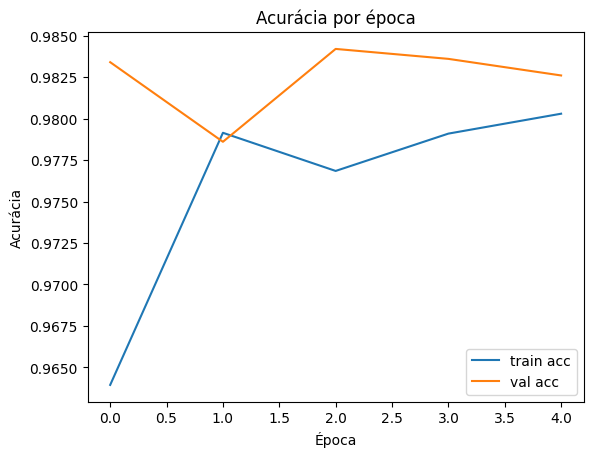

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Acurácia por época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.show()

## 8. Predição de exemplo

In [13]:
sample_path = data_val.filepaths[0]
img = image.load_img(sample_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]
print(f"Imagem: {sample_path}\nPrevisão: {'Dog' if pred > 0.5 else 'Cat'} (confiança: {pred:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Imagem: dataset_split/val/Cat/1.jpg
Previsão: Cat (confiança: 0.00)
